In [42]:
import os, subprocess, json, time
from typing import Dict

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

In [43]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
seq_db = os.path.join(base_dir, "input", "sequence_db")

#Path to the benchmark databases
db_len_path = os.path.join(base_dir, "input", "sequence_db", "BM_db_e6")
db_nb_path = os.path.join(base_dir, "input", "sequence_db", "BM_db_100")

out_analysis_path = os.path.join(base_dir, "output", "analysis")

#Path to the modules
db_code = os.path.join(base_dir, "code")

# Benchmark of the detection of HGT by the different metrics

In [44]:
def prepare_HGT_db(input_db : str, output_db : str, iterations : int = 1000, proba : float = 0.05):
    """
    Prepare the artificial database of HGTs
    """
    os.chdir(db_code)
    subprocess.run(
        ['python', '-m' ,'HGTransfer','-db',str(input_db), '-o', str(output_db), '-i', str(iterations), '-p', str(proba)]
        )
    return output_db

def compute_signatures(input_db : str, metric_num : int, metric_name : str):
    """
    Compute the signatures for the database where HGT occured
    """
    os.chdir(db_code)

    subprocess.run(
        ["python","-m","compute_signatures",str(input_db),"-m",str(metric_num)]
    )
    return f"{input_db}_{metric_name}.json"

def backtrack_analysis(output_db : str, json_file : str, eval_file : str):
    """
    Compute the backtrack analysis for detected HGTs into the database.
    """
    os.chdir(db_code)

    subprocess.run([
        "python","-m","analysis",str(json_file),str(output_db),"-r",str(eval_file)]
    )
    return 0

In [49]:
def load_summaries(output_db, ref_file : str, json_file : str):
    """
    Load files for evaluation.
    """
    json_path = os.path.join(base_dir, "output", "transfer_summary", json_file)
    with open(json_path, 'r', encoding='utf-8') as jfile :
        json_raw = json.load(jfile)

    ref_path = os.path.join(seq_db, output_db, ref_file)

    with open(ref_path, 'r') as ref_raw :
        ref_raw = ref_raw.readlines()
    
    ref_dico = {}
    for ref in ref_raw[1:]:
        sending, sd_start, sd_end, receiving, rc_pos = ref.split('\t\t')
        ref_dico[receiving] = int(rc_pos.strip())
    return json_raw, ref_dico


def eval(json_raw : Dict[str, Dict[int, float]], ref_dico : Dict[str, int], window : int = 10000):
    """
    Check how many generated HGT are caught.
    """
    count = 0
    for receiver, position in ref_dico.items():
        if len(json_raw[receiver]) == 0:
            continue

        if any((position > int(loc)-2*window and position < int(loc)+2*window) for loc, intensity in json_raw[receiver].items()):
            count += 1
    
    return count

def get_backtrack_results(eval_report_path : str, path_db_report : str):
    with open(eval_report_path, 'r') as eval_report:
        report = len(eval_report.readlines())
    
    with open(path_db_report, 'r') as generator_report:
        generator_size = len(generator_report.readlines())
    return report, generator_size

        
def benchmark_HGT_detection(input_db : str, output_db : str):
    couples_metric = { 
        "L2_distance" : 0,
        "Chi-squared_distance" : 1,
        "KL_divergence" : 2,
        "average_frequency" : 3
    }
    results_metric = {metric : {"Accuracy score" : 0, "Hit ratio" : 0} for metric in couples_metric.keys()}
    stats_metric = {metric : {"TP" : 0, "FN":0, "Time (s)" : 0} for metric in couples_metric.keys()}

    output_db = prepare_HGT_db(input_db, output_db, proba=0.005)
    gen_db_report = os.path.join(seq_db, output_db, "HGT_report.txt")

    for metric_name, num_metric in couples_metric.items():
        json_summary = compute_signatures(output_db, metric_name=metric_name, metric_num=num_metric)
        json_raw, ref_dico = load_summaries(output_db, "HGT_report.txt", json_summary)
        
        avg_finding = sum([len(summary) for summary in json_raw.values()])/len(json_summary)
        print(avg_finding)
        
        found_HGT = eval(json_raw, ref_dico)
        results_metric[metric_name]["Accuracy score"] = found_HGT/len(ref_dico) # accuracy respect to artificial HGT
        results_metric[metric_name]["Hit ratio"] = found_HGT/avg_finding

        st = time.time()
        backtrack_analysis(output_db, json_summary, gen_db_report)

        eval_report_path = os.path.join(out_analysis_path, "eval_analysis_report.txt")
        tp, tot_HGT = get_backtrack_results(eval_report_path, gen_db_report)
        fn = tot_HGT-tp

        stats_metric[metric_name]["TP"] = tp
        stats_metric[metric_name]["FN"] = fn
        stats_metric[metric_name]['Time (s)'] = round(time.time()-st, 4)

        print(metric_name, results_metric,stats_metric, sep='\n')
    
    return pd.DataFrame(data=results_metric), pd.DataFrame(data=stats_metric)
    
result_df, stats_df = benchmark_HGT_detection("Brinkman", "generator_db")

Starting HGTdb generation...
  Cleaning output directory...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0%  

HGT database is Ready.
Refer to the file HGT_report.txt for the list of the transfers that occured.
Files can be found in the input/sequence_db/generator_db
Progress: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete
Total time: 30.34s
Average time to compute kmers: 1.23s
Average time to compute windows: 1.72s
7.103448275862069
Loading transfer summary
  Output directory cleaned.

Starting backtracking...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Average runtime per transfer summary 2
Total Runtime 14
66.67% of the HGT from the reference file were found.
Starting graph computation


/home/tristan/workspace/GENOM/code/analysis/graph.py:36: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  source = pd.read_csv(source, delimiter='\t\t')


L2_distance
{'L2_distance': {'Accuracy score': 1.0, 'Hit ratio': 0.4223300970873786}, 'Chi-squared_distance': {'Accuracy score': 0, 'Hit ratio': 0}, 'KL_divergence': {'Accuracy score': 0, 'Hit ratio': 0}, 'average_frequency': {'Accuracy score': 0, 'Hit ratio': 0}}
{'L2_distance': {'TP': 27, 'FN': -23, 'Time (s)': 15.0154}, 'Chi-squared_distance': {'TP': 0, 'FN': 0, 'Time (s)': 0}, 'KL_divergence': {'TP': 0, 'FN': 0, 'Time (s)': 0}, 'average_frequency': {'TP': 0, 'FN': 0, 'Time (s)': 0}}
Progress: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete
Total time: 30.13s
Average time to compute kmers: 1.23s
Average time to compute windows: 1.68s
2.736842105263158
Loading transfer summary
  Output directory cleaned.

Starting backtracking...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Average runtime per transfer summary 1
Total Runtime 7
66.67% of the HGT fr

/home/tristan/workspace/GENOM/code/analysis/graph.py:36: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  source = pd.read_csv(source, delimiter='\t\t')


Chi-squared_distance
{'L2_distance': {'Accuracy score': 1.0, 'Hit ratio': 0.4223300970873786}, 'Chi-squared_distance': {'Accuracy score': 0.6666666666666666, 'Hit ratio': 0.7307692307692307}, 'KL_divergence': {'Accuracy score': 0, 'Hit ratio': 0}, 'average_frequency': {'Accuracy score': 0, 'Hit ratio': 0}}
{'L2_distance': {'TP': 27, 'FN': -23, 'Time (s)': 15.0154}, 'Chi-squared_distance': {'TP': 29, 'FN': -25, 'Time (s)': 7.8544}, 'KL_divergence': {'TP': 0, 'FN': 0, 'Time (s)': 0}, 'average_frequency': {'TP': 0, 'FN': 0, 'Time (s)': 0}}
Progress: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete
Total time: 50.68s
Average time to compute kmers: 1.25s
Average time to compute windows: 5.11s
5.129032258064516
Loading transfer summary
  Output directory cleaned.

Starting backtracking...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Average runtime per tran

/home/tristan/workspace/GENOM/code/analysis/graph.py:36: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  source = pd.read_csv(source, delimiter='\t\t')


KL_divergence
{'L2_distance': {'Accuracy score': 1.0, 'Hit ratio': 0.4223300970873786}, 'Chi-squared_distance': {'Accuracy score': 0.6666666666666666, 'Hit ratio': 0.7307692307692307}, 'KL_divergence': {'Accuracy score': 1.0, 'Hit ratio': 0.5849056603773585}, 'average_frequency': {'Accuracy score': 0, 'Hit ratio': 0}}
{'L2_distance': {'TP': 27, 'FN': -23, 'Time (s)': 15.0154}, 'Chi-squared_distance': {'TP': 29, 'FN': -25, 'Time (s)': 7.8544}, 'KL_divergence': {'TP': 32, 'FN': -28, 'Time (s)': 12.4055}, 'average_frequency': {'TP': 0, 'FN': 0, 'Time (s)': 0}}
Progress: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete
Total time: 31.37s
Average time to compute kmers: 1.26s
Average time to compute windows: 2.14s
6.914285714285715


/home/tristan/workspace/GENOM/code/analysis/eval.py:55: SyntaxWarning: invalid escape sequence '\S'
  """


Loading transfer summary
  Output directory cleaned.

Starting backtracking...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Average runtime per transfer summary 3
Total Runtime 16
66.67% of the HGT from the reference file were found.
Starting graph computation


/home/tristan/workspace/GENOM/code/analysis/graph.py:36: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  source = pd.read_csv(source, delimiter='\t\t')


average_frequency
{'L2_distance': {'Accuracy score': 1.0, 'Hit ratio': 0.4223300970873786}, 'Chi-squared_distance': {'Accuracy score': 0.6666666666666666, 'Hit ratio': 0.7307692307692307}, 'KL_divergence': {'Accuracy score': 1.0, 'Hit ratio': 0.5849056603773585}, 'average_frequency': {'Accuracy score': 1.0, 'Hit ratio': 0.43388429752066116}}
{'L2_distance': {'TP': 27, 'FN': -23, 'Time (s)': 15.0154}, 'Chi-squared_distance': {'TP': 29, 'FN': -25, 'Time (s)': 7.8544}, 'KL_divergence': {'TP': 32, 'FN': -28, 'Time (s)': 12.4055}, 'average_frequency': {'TP': 34, 'FN': -30, 'Time (s)': 17.0347}}


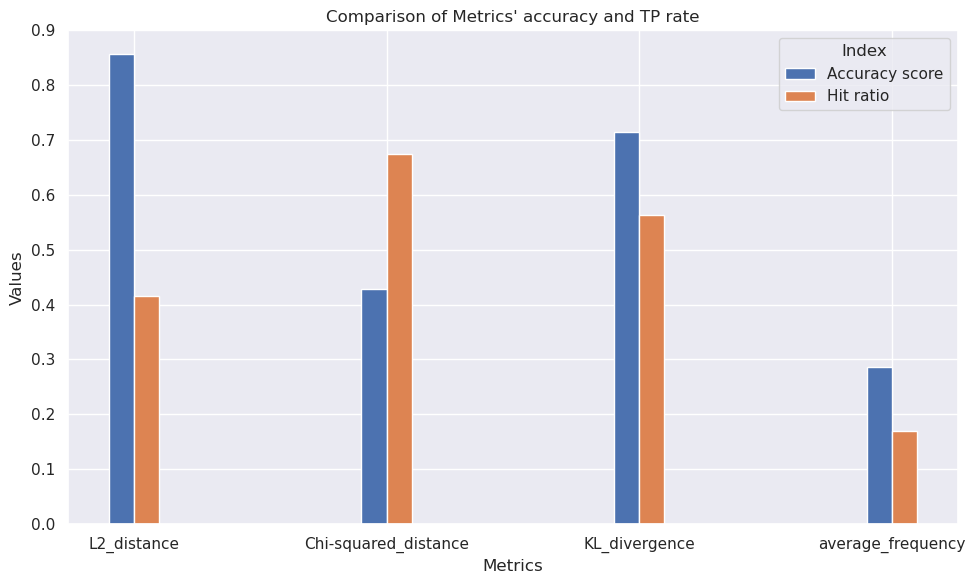

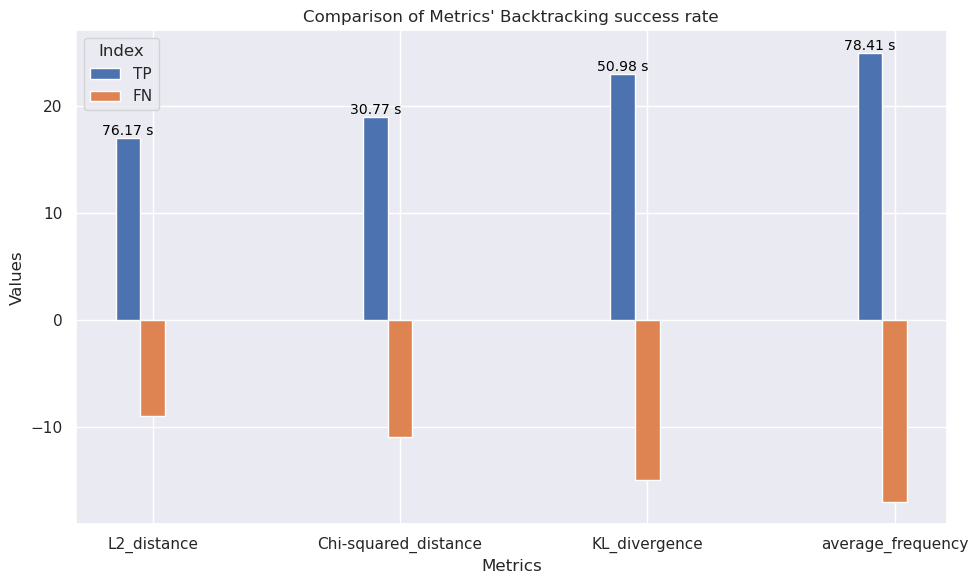

In [46]:
def show_results(result_df: pd.DataFrame, job : str):
    bar_width = 0.1  
    indices = np.arange(len(result_df.columns))  
    index_labels = result_df.index  

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, index in enumerate(result_df.index):
        if index == "Time (s)":
            break
        ax.bar(indices + i * bar_width, result_df.loc[index,:], bar_width, label=index)

    if "Time (s)" in result_df.index:
        for i, col in enumerate(result_df.columns):
            tp, fn, time = result_df[col].values

            max_value = np.array([tp, fn]).max()
            max_index = np.array([tp, fn]).argmax()
            ax.text(
                indices[i] + max_index *bar_width,  
                max_value + 0.01,                    # Y-coordinate (slightly above the bar)
                f"{time:.2f} s",                 # Text to display (rounded to 2 decimal places)
                ha="center",                        # Center alignment
                va="bottom",                        # Bottom alignment
                fontsize=10,                        # Font size
                color="black",                 # Text color
            )

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(f"Comparison of Metrics' {job}")
    ax.set_xticks(indices + bar_width * (len(index_labels) - 1) / 2)
    ax.set_xticklabels(result_df.columns)
    ax.legend(title="Index")

    plt.tight_layout()
    plt.show()


show_results(result_df, "accuracy and TP rate")
show_results(stats_df, "Backtracking success rate")

In [47]:
stats_df

,L2_distance,Chi-squared_distance,KL_divergence,average_frequency
TP,17.0000,19.0000,23.0000,25.0000
FN,-9.0000,-11.0000,-15.0000,-17.0000
Time (s),76.1736,30.7674,50.9814,78.4123


In [48]:
result_df

,L2_distance,Chi-squared_distance,KL_divergence,average_frequency
Accuracy score,0.857143,0.428571,0.714286,0.285714
Hit ratio,0.416268,0.674556,0.563636,0.170316
